In [11]:
from config.help_functions import *
from config.config import *
from header_libs import *

# 1. Úvod

Cieľom tohto projektu je navrhnúť a optimalizovať model umelej neurónovej siete pre klasifikáciu porúch na oceľových plátoch.
Projekt využíva dátovú sadu Steel Plates Faults Dataset a testuje viacero prístupov pomocou W&B Sweep na automatické ladenie hyperparametrov.

Model je primárne implementovaný v knižnici **PyTorch**, výsledky a priebeh tréningu sú logované pomocou **Weights & Biases** (wandb).

**Hlavné ciele:**

- analyzovať kvalitu a štruktúru datasetu,

- porovnať binárnu a multiklasifikačnú verziu problému,

 - otestovať rôzne konfigurácie modelu pre jednotlivé klasifikácie

 - vyhodnotiť, ktoré parametre majú najväčší vplyv na výkon modelu, a ktorá konfikurácia je na základe našich experimentov najlepšia na riešenie daných problémov. ( výkon modelu sme merali pomocou metrík: precission, recall a F1)

pouzite kniznice so far:
pandas ,scikit-learn, torch, seaborn, numpy, wandb


# 2. Analýza dát
## 2.1 Informácie o datasete
(potrobnejšie info o data sete máme z https://www.kaggle.com/datasets/uciml/faulty-steel-plates )
Prvne sme zanalizovali veľkosť našeho data setu. Má 1941 položiek pričom každá položka má 34 stĺpcov.

Pokiaľ si zobereme čo aký stĺpec znamená, tak prvých 27 mi určuje parametre položky (v našom prípade sa jedná o Oceľové Pláty). Parametre sú celočíeslne (14 stĺpcov) alebo reálne (13. stĺpcov) hodnoty. Niektoré tieto parametre sú napríklad:

**X_Minimum
X_Maximum
Y_Minimum
Y_Maximum
Pixels_Areas
X_Perimeter
Y_Perimeter
Sum_of_Luminosity
Minimum_of_Luminosity ... **

Posledných 7 stĺpcov nám určuje či daná položka ma nejakú vadu. Prvých 6 je nejaká konkrétna vada a posledná nam určuje či položka je vadná (0) alebo nie (1). Tieto stĺpce máju boolovsku hodnotu (čiže 0 alebo 1). Pričom 0 znamená, že daná položka nemá túto vadu a 1 zase znamená, že túto vadu obsahuje. Možné vady sú:

    Pastry
    Z_Scratch
    K_Scatch
    Stains
    Dirtiness
    Bumps


## 2.2 Kontrola kvality dát

Data set neobsahuje žiadne alebo duplicitné dáta.

In [12]:
import pandas as pd

df = pd.read_csv("faults.csv")
print(df.shape)

print("Mame chybajuce hodnoty?")
print(df.isna().sum().sum())
print("Mame duplikaty?")
print(df.duplicated().sum())


(1941, 34)
Mame chybajuce hodnoty?
0
Mame duplikaty?
0


## 2.3 Korelačná analýza

Keďže nemáme chýbajúce hodnoty ani duplikátne hodnoty môžeme ísť rovno k ďaľším krokom. Zistíme si koreláciu medzi dátami v našom data sete pomocou "Heatmap". Najrpv medzi vstupnými dátami, kde vidíme, že medzi niektorími vstupnými dátami je vysoká priama korelácia, to znaméná že narastajú vzájomne lineárne a neskôr do MLPčka by nepridávali žiadne nové dáta.





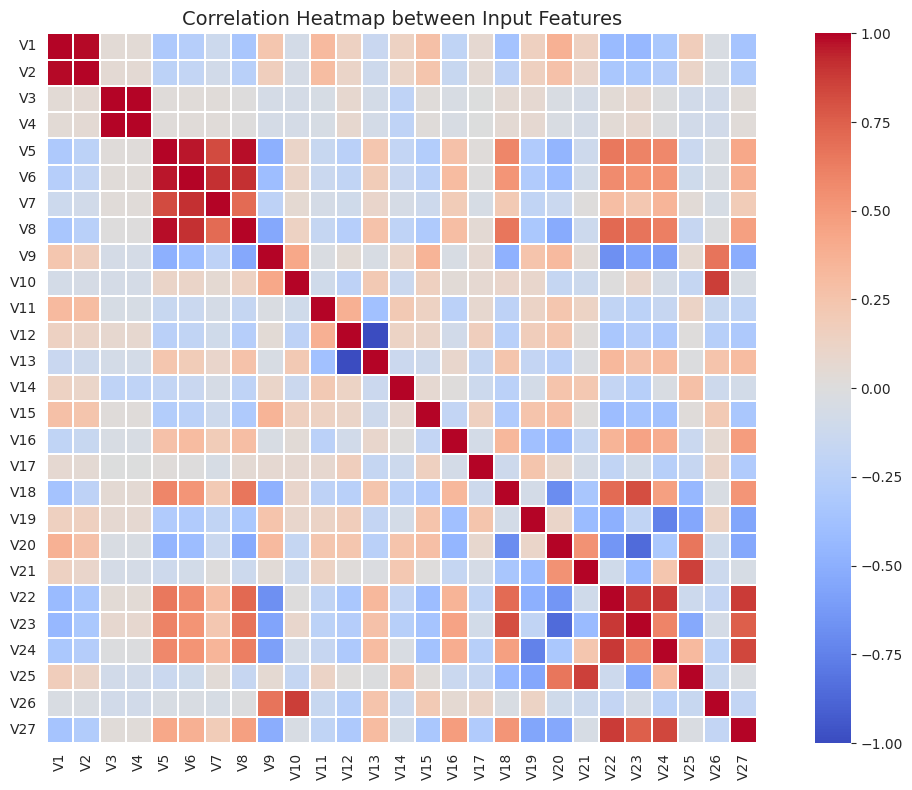

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("faults.csv")

# Select only input features (V1–V27)
input_columns = [f"V{i}" for i in range(1, 28)]  # up to 27 inclusive
input_df = df[input_columns]
corr = input_df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=False,
    linewidths=0.3,
    square=True
)
plt.title("Correlation Heatmap between Input Features", fontsize=14)
plt.tight_layout()
plt.show()


Z korelačnej heatmapy je viditeľné, že niektoré vstupné atribúty (napr. V22, V23) silno korelujú s konkrétnymi typmi chýb (V29, V30), zatiaľ čo iné majú opačný – záporný vzťah. Korelácia so stĺpcom Class je však nízka, čo naznačuje, že žiadna premenná sama o sebe nedokáže spoľahlivo určiť chybnosť vzorky.

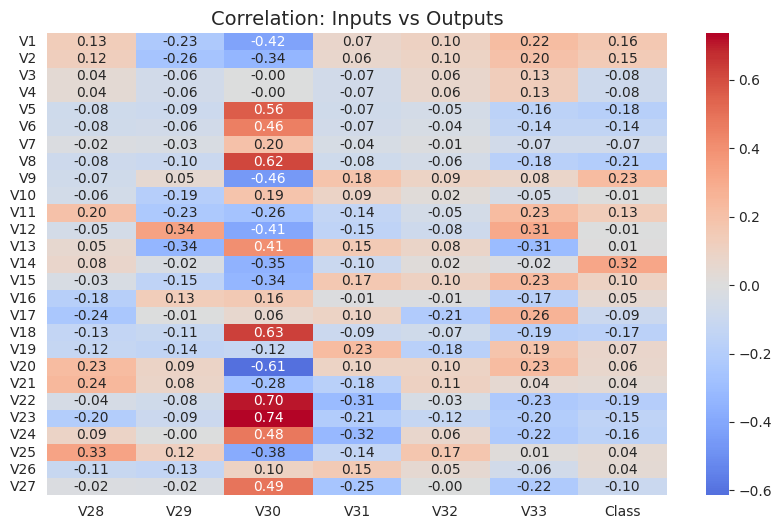

In [14]:


input_columns = [f"V{i}" for i in range(1, 28)]  # V1–V27
outputs = FAULT_COLUMNS+['Class']

corr = df[input_columns + outputs].corr(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(
    corr.loc[input_columns, outputs],
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    center=0
)

plt.title("Correlation: Inputs vs Outputs", fontsize=14)
plt.show()


## 2.4 Odstránenie redundantných atribútov

Z korelačnej heatmapy vstupných parametrov vyplýva, že viacero atribútov vykazuje silnú lineárnu závislosť (|r| > 0.9).

Je viacero dvojíc, ktoré majú priamu alebo nepriamu linearnu koreláciu, napríklad V1-V2 , V3-V4, V5-V6, V5-V8 , V12-V13 , V20-V23. Z každej dvojice, ponecháme jednu premennú, čiže odstránime V2,V4,V6,V8,V13 a V21.

In [15]:
df = pd.read_csv("faults.csv")

cols_to_drop = ['V2', 'V4', 'V6', 'V8', 'V21']
df_reduced = df.drop(
    columns=['V2', 'V4', 'V6', 'V8', 'V21'], errors='ignore')

df_reduced.to_csv(
    "faults_reduced.csv",
    index=False)

## 2.5 Zastúpenie jednotlivých výstupov
### 2.5.1 Multiklasifikačné výstupy
Zastúpenie rôznych chýb,ktoré vieme kvalifikovať, je nerovnomerné. Toto môže ovplyvniť trénovanie. Preto neskôr do našeho modelu zavedieme trošku prísnejší 'trestací systém', ktorí bude viac brať ohľad na premenné, ktoré sú v menšiom zastupení.
### 2.5.2 Binárne výstupy
Pri stĺpci, ktorý nám určuje, či daný Oceľový plát je chybný alebo nie, zistíme, že zastúpenie bezzávadných a závadnych záznamov je približne 7:13. Čož môžeme považovať za mierne nevyvážené zastúpenie.

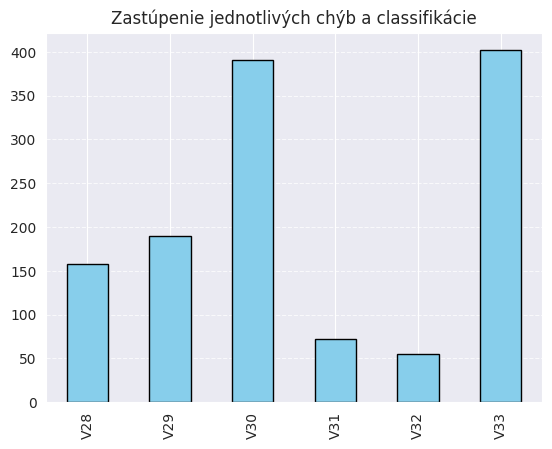

In [16]:
output_cols = df.iloc[:, -7:-1]
sums = output_cols.sum()
sums.plot(kind='bar',color='skyblue', edgecolor='black')
plt.title('Zastúpenie jednotlivých chýb a classifikácie')
plt.grid(axis='y', linestyle='--', alpha=0.75)
plt.show()

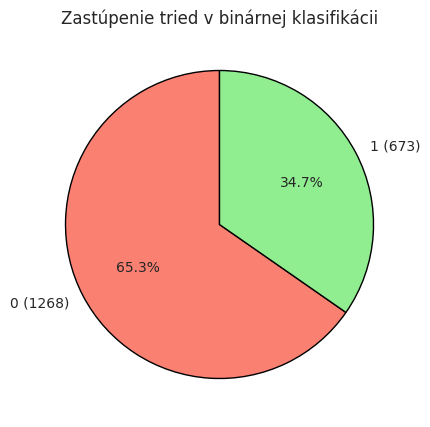

In [17]:
last_col = df.iloc[:, -1]
counts = last_col.value_counts().sort_index()
plt.figure(figsize=(5,5))
plt.pie(
    counts,
    labels=[f"{cls} ({counts[cls]})" for cls in counts.index],
    autopct='%1.1f%%',
    startangle=90,
    colors=[ 'salmon', 'lightgreen' ],
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Zastúpenie tried v binárnej klasifikácii')
plt.show()

## 2.6 Normalizácia dát
V rámci experimentov boli otestované rôzne prístupy k normalizácii vstupných dát s cieľom zistiť, ktorý z nich vedie k najlepšej stabilite a presnosti modelu.
Testované boli nasledujúce metódy:

- **StandardScaler** – štandardizácia (z-score), ktorá upravuje dáta na nulový priemer a jednotkovú smerodajnú odchýlku.
- **RobustScaler** – normalizácia založená na mediáne a IQR (interkvartilovom rozpätí), odolná voči odľahlým hodnotám.
- **PowerTransformer** – nelineárna transformácia dát s cieľom priblížiť ich k normálnemu rozdeleniu.
- **QuantileTransformer** – mapovanie hodnôt podľa kvantilov na rovnomerné rozdelenie.
- **MinMaxScaler(0, 1)** – prevod hodnôt do intervalu ⟨0, 1⟩.
- **MinMaxScaler(0, 10)** – prevod hodnôt do širšieho intervalu ⟨0, 10⟩ pre porovnanie efektu mierky.

Z výsledkov experimentov vyplýva, že najlepšie výsledky (najvyššia validačná presnosť a stabilná konvergencia) dosiahla **MinMax normalizácia v intervale ⟨0, 1⟩**, ktorá zabezpečila vyvážený rozsah vstupných hodnôt pre všetky atribúty.
Ostatné metódy, ako napríklad štandardizácia alebo robustná škálovacia transformácia, vykazovali mierne horšiu presnosť alebo pomalšiu konvergenciu modelu.


In [18]:
import pandas as pd
from config.help_functions import get_scaler

df = pd.read_csv("faults_reduced.csv")

output_cols = ['V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'Class']

X = df.drop(columns=output_cols)
Y = df[output_cols]

scaler = get_scaler(type="minmax", interval=(0, 1))
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

df_normalized = pd.concat(
    [X_scaled_df,
     Y.reset_index(drop=True)],
    axis=1
)

df_normalized.to_csv("faults_reduced_normalized.csv",
                     index=False)


## 2.7 Zhrnutie analýzy dát

Dataset obsahuje 1941 vzoriek a 27 číselných atribútov, ktoré opisujú geometrické a fyzikálne vlastnosti oceľového plátu.
Každý záznam patrí aspoň do jednej z 7 tried porúch: Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps.

Analýza ukázala, že niektoré atribúty sú silne korelované (r > 0.9), preto boli redundantné stĺpce odstránené.
Následne boli všetky atribúty normalizované pomocou `MinMaxScaler` do intervalu ⟨0, 1⟩.

Pri binárnej klasifikácii boli všetky typy chýb zlúčené do jednej výstupnej premennej `Class`, kde 0 = bezchybný plát a 1 = chybný plát.
Dáta neobsahovali chýbajúce hodnoty ani zjavné outliery.

Keďže počet bezchybných vzoriek výrazne prevyšuje počet chybných, dataset je **nevyvážený**.
Preto sa ako hlavná metrika hodnotenia použila **F1 score**, ktorý lepšie vystihuje pomer medzi presnosťou a citlivosťou modelu. Ako ostatné metriky sme použili taktiež **Recall**, **Precision**.

> Výsledkom analýzy je upravený a znormalizovaný dataset `faults_reduced_normalized.csv`, pripravený na trénovanie modelu.


# 3. Metodológia

Cieľom metodiky je navrhnúť a otestovať jednoduchý plne prepojený neurónový model (**Multi-Layer Perceptron – MLP**) schopný klasifikovať defekty na oceľových plátoch.


## 3.1 Architektúra modelu

Model je implementovaný v triede **`SteelNet`**, ktorá predstavuje všeobecnú architektúru MLP pre klasifikáciu.
Obsahuje dve plne prepojené (dense) skryté vrstvy s voliteľnou veľkosťou a dropout regularizáciou. V skrytých vrstvách sa taktiež budú testovať rôzne normalizačné moduly.
Architektúra je rovnaká pre binárnu aj multiklasifikačnú úlohu, avšak jej konfigurácia sa môže vo výsledku ľíšiť.


## 3.2 Parametre architektúry
- `hidden1`, `hidden2` – veľkosť skrytých vrstiev
- `dropout1`, `dropout2` – dropout koeficienty (0.0–0.4)
- `optimizer` – výber optimalizačného algoritmu (`adam`, `sgd`, `rmsprop`)
- `learning_rate` – rýchlosť učenia
- `binary` – prepínač medzi binárnou a multiklasifikačnou úlohou

Model používa aktivačnú funkciu **ReLU**, pričom výstupná vrstva používa **Sigmoid** na namapovanie dát medzi 0 a 1.

---

## 3.2 Stratová funkcia

Podľa typu úlohy sa automaticky volí stratová funkcia:
- **`BCELoss`** pre binárnu klasifikáciu (defektný / bezchybný plát)
- **`CrossEntropyLoss`** pre multiklasifikačný problém (7 typov chýb)

Pri multikvalifikačný model sa automaticky vypočítajú **váhy tried podľa ich frekvencie**, aby sa zmiernila nevyváženosť datasetu.

Tieto váhy sú následne použité v stratovej funkcii.

## 3.3 Tréningový postup
Najprv si nakonfigurujeme konfiguráciu ktorú chceme otestovať (pomocou súboru config v súbore config)
Tréning je implementovaný v metóde **`fit()`**, ktorá zahŕňa:
1. dopredný priechod (forward pass)
2. výpočet straty (`criterion`)
3. spätné šírenie chyby (`backward()`)
4. aktualizáciu váh (`optimizer.step()`)

Počas tréningu sa sledujú tieto metriky:
- **Accuracy** – podiel správnych predikcií
- **Precision**, **Recall**, **F1 score** – pre detailné hodnotenie výkonu
- **Validation loss** – pre detekciu preučenia

Pre stabilizáciu tréningu sa používa **early stopping**:
ak sa validácia nezlepší počas predom nastaveného počtu epoch, tak tréning sa automaticky zastaví.



## 3.4 Ladenie konfigurácie

Ladenie prebieha pomocou nástroja **Weights & Biases Sweeps**, ktorý automaticky generuje rôzne konfigurácie parametrov.
Každý experiment spustí samostatný tréning s vlastnými hodnotami:

| Parameter | Rozsah / hodnoty |
|------------|------------------|
| `batch_size` | [32, 64, 128] |
| `learning_rate` | [1e-4 – 1e-2] |
| `optimizer` | [adam, sgd, rmsprop] |
| `hidden1` | [64, 128, 256] |
| `hidden2` | [64, 128] |
| `dropout1`, `dropout2` | [0.0 – 0.4] |
| `seed` | [42, 69, 1337] |

Každý beh loguje priebeh tréningu (loss, accuracy, F1, precision, recall) priamo do **W&B dashboardu**.
Optimalizačná metóda sweepu je **Bayesian optimization**, ktorá iteratívne vyberá najpravdepodobnejšie dobré kombinácie parametrov.


###  3.5 Cieľ experimentov

Cieľom experimentov bolo:
- porovnať vplyv jednotlivých optimalizátorov (SGD, Adam, RMSprop)
- otestovať efekt dropoutov na presnosť modelu
- určiť optimálnu veľkosť skrytých vrstiev a learning rate
- určiť, aký typ normalizácie na **skrytej vrstve** má najlepšie výsledky
- - určiť, aký typ normalizácie na **vstupných dátach** má najlepšie výsledky
- nájsť konfiguráciu s najvyšším **F1 score**

---
Možnosť vyskúšať, svoju konfiguráciu

Using device: cpu
Epoch 2/100
Best val Acc: 0.7392795883361921
Epoch 3/100
Best val Acc: 0.7392795883361921
Epoch 4/100
Best val Acc: 0.7392795883361921
Epoch 5/100
Best val Acc: 0.7461406518010292
Epoch 6/100
Best val Acc: 0.7461406518010292
Epoch 7/100
Best val Acc: 0.7615780445969125
Epoch 8/100
Best val Acc: 0.7615780445969125
Epoch 9/100
Best val Acc: 0.7615780445969125
Epoch 10/100
Best val Acc: 0.7615780445969125
Epoch 11/100
Best val Acc: 0.7615780445969125
Epoch 12/100
Best val Acc: 0.7615780445969125
Epoch 13/100
Best val Acc: 0.7615780445969125
Epoch 14/100
Best val Acc: 0.7615780445969125
Epoch 15/100
Best val Acc: 0.7615780445969125
Epoch 16/100
Best val Acc: 0.7615780445969125
Epoch 17/100
Best val Acc: 0.7615780445969125
Epoch 18/100
Best val Acc: 0.7667238421955404
Epoch 19/100
Best val Acc: 0.7667238421955404
Epoch 20/100
Best val Acc: 0.7667238421955404
Epoch 21/100
Best val Acc: 0.7667238421955404
Epoch 22/100
Best val Acc: 0.7667238421955404
Epoch 23/100
Best val Ac

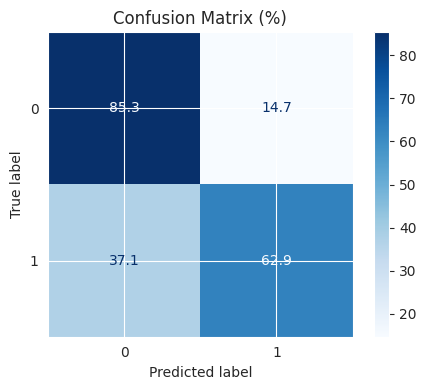

array([[85.30183727, 14.69816273],
       [37.12871287, 62.87128713]])

In [19]:
from config.wandb_config import *
from config.help_functions import *
from Model import *


BINARY_CLASSIFICATION= True

#===| Seed preparation |===#
#==============================================================#
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#==============================================================#

X_train, X_val , y_train, y_val, train_loader, val_loader, y = (
    split("faults_reduced_normalized.csv",BINARY_CLASSIFICATION, DATA_SPLIT))

#===| Preparations |===#
#==============================================================#
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if BINARY_CLASSIFICATION:
    model = SteelNet(
        X_train.shape[1],
        1,
        PARAMS,
        binary=True
    ).to(device)
else:
    model = SteelNet(
        X_train.shape[1],
        len(np.unique(y)),
        PARAMS,
        binary=False,
        targets=y_train
    ).to(device)
#==============================================================#


#===| Training and Logging|===#
#==============================================================#
best_model, best_val_acc = model.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    logger=run,
    logging=True,
    device=device,
    max_epochs=100,
)
#==============================================================#

print("\n✅ Training finished — plotting confusion matrix...")
plot_confusion_matrix(model, val_loader, device, binary=BINARY_CLASSIFICATION)


# 4. Výsledky experimentov

Táto časť je zameraná na analýzu a zhodnotenie jednotlivých parametrov, optimalizátorov a metód, ako aj ich vplyvu na výsledky neurónovej siete.
Popíšeme priebeh experimentov, porovnáme výkonnosť rôznych modelov a vyhodnotíme výsledky sweepu, ktorého cieľom bolo nájsť optimálne nastavenie siete.



## 4.1 Vplyv optimalizátorov

Výber optimalizátora mal výrazný vplyv na efektivitu a kvalitu trénovania modelu.
Z testovaných možností sa najlepšie osvedčil **Adam** a **RMSprop**, ktoré zabezpečovali rýchlu konvergenciu a stabilný pokles chyby.
Naopak, **SGD** mal pomalšiu adaptáciu, no v niektorých konfiguráciách dosiahol najvyššiu presnosť na validačných dátach vďaka lepšej generalizácii.





## 4.2 Vplyv parametrov

Experimenty ukázali, že parametre ako **počet neurónov**, **dropout** a **learning rate** majú kľúčový vplyv na výkon modelu.
Vyšší počet neurónov v prvej vrstve zlepšil schopnosť siete zachytiť komplexnejšie vzory, no zároveň zvýšil riziko preučenia.
Dropout v rozsahu **0.1–0.3** poskytoval najlepšiu rovnováhu medzi presnosťou a generalizáciou, zatiaľ čo príliš vysoké hodnoty (>0.4) zhoršovali konvergenciu.



## 4.3 Vyhodnotenie výsledkov sweepu

Sweep experiment realizovaný cez **Weights & Biases** umožnil automatizovane testovať stovky kombinácií parametrov.
Zamerali sme sa na:
- vplyv architektúry modelu na presnosť,
- efekt regularizácie a dropout vrstiev,
- dopad rýchlosti učenia a typu optimalizátora.

Najlepšie výsledky dosiahli modely, ktoré využívali **Batch Normalization**, **dropout 0.1–0.3** a **learning rate v rozmedzí 0.001–0.004**.

<iframe
  src="https://api.wandb.ai/links/nikolaskekelak-fiit-stu/fgxwvr5a"
  width="100%"
  height="420"
  frameborder="0"></iframe>



## 4.4 Naše najlepšie modely

V tabuľkách nižšie sú uvedené najlepšie konfigurácie pre jednotlivé typy klasifikácie – **multiklasifikačný**, **binárny** a **hybridný** model.
Všetky modely boli testované na rovnakej množine dát a s rovnakou štruktúrou vrstiev, líšili sa iba parametrami učenia a typom výstupnej vrstvy.



##  Najlepšia konfigurácia pre **multiklasifikačný model**
| Parameter | Hodnota |
|------------|----------|
| `batch_size` | 128 |
| `learning_rate` | 0.001178 |
| `optimizer` | sgd |
| `hidden1` | 256 |
| `hidden2` | 64 |
| `dropout1` | 0.3716 |
| `dropout2` | 0.1427 |
| `seed` | 42 |
| **Validation Accuracy** | **0.95** |
| **F1** | **0.94** |
| **Recall** | **0.94** |
| **Precision** | **0.93** |



## Najlepšia konfigurácia pre **binárnu klasifikáciu**
| Parameter | Hodnota |
|------------|----------|
| `batch_size` | 64 |
| `learning_rate` | 0.0031 |
| `optimizer` | adam |
| `hidden1` | 256 |
| `hidden2` | 32 |
| `dropout1` | 0.151 |
| `dropout2` | 0.061 |
| `seed` | 69 |
| **Validation Accuracy** | **0.79** |
| **F1** | **0.69** |
| **Recall** | **0.70** |
| **Precision** | **0.68** |

## Confusion Matrix pre najlepší binárny model

| | Predikované: Bez chyby | Predikované: Chyba |
|---|---|---|
| **Skutočné: Bez chyby** | **83 %** | 17 % |
| **Skutočné: Chyba** | 29 % | **71 %** |

Model mal tendenciu preferovať triedu „bez chyby“, no pri správnom nastavení prahovej hodnoty dosahoval spoľahlivú detekciu defektov.
V praxi by bolo možné túto chybu kompenzovať úpravou stratovej funkcie alebo pridaním váh pre menej zastúpenú triedu.



## Najlepšia konfigurácia pre **hybridnú architektúru**
| Parameter | Hodnota |
|------------|----------|
| `batch_size` | 128 |
| `learning_rate` | 0.001178 |
| `optimizer` | adam |
| `hidden1` | 128 |
| `hidden2` | 128 |
| `dropout1` | 0.095 |
| `dropout2` | 0.2577 |
| `seed` | 42 |
| **Validation Accuracy** | **0.82** |
| **F1** | **0.85** |
| **Recall** | **0.877** |
| **Precision** | **0.839** |



## 4.5 Porovnanie optimalizačných a normalizačných modulov

Okrem zmeny architektúry a parametrov sme testovali aj vplyv rôznych **normalizačných a regularizačných vrstiev** na výsledný výkon siete.
Z tabuľky nižšie vyplýva, že **Batch Normalization** a klasický **Dropout** dosahovali najlepšie výsledky, zatiaľ čo *LayerNorm* a *GroupNorm* priniesli len mierne zlepšenie oproti sieťam bez normalizácie.



## 4.6 Výsledky porovnania normalizačných a regularizačných modulov
| Typ modulu | Konfigurácia | Validation Accuracy |
|-------------|--------------|---------------------|
| **Dropout** | (0.2, 0.2) | **0.8522** |
| **Dropout** | (0.2, 0.1) | **0.8522** |
| **Dropout** | (0.1, 0.1) | 0.8454 |
| **AlphaDropout** | (0.2, 0.2) | 0.7835 |
| **AlphaDropout** | (0.1, 0.1) | 0.8144 |
| **BatchNorm** | – | **0.8522** |
| **LayerNorm** | – | 0.8351 |
| **GroupNorm** | – | 0.8316 |
| **Bez normalizácie** | – | 0.7732 |



## 4.6 Zhrnutie výsledkov experimentov

Z experimentov vyplynulo, že správna voľba architektúry a parametrov má zásadný vplyv na kvalitu učenia neurónovej siete.
Najlepšiu výkonnosť dosiahol **multiklasifikačný model** s využitím vrstiev *Batch Normalization* a *Dropout (0.37 / 0.14)*, ktorý dosiahol až **95 % presnosť** a **F1 = 0.94**.
**Binárny model** sa ukázal ako stabilnejší pri samotnej detekcii výskytu chyby, zatiaľ čo **hybridný prístup** poskytol dobrý kompromis medzi presnosťou a generalizáciou.

Porovnanie normalizačných techník potvrdilo, že kombinácia **BatchNorm + Dropout** je pre túto úlohu najefektívnejšia.
Výsledky zároveň ukázali, že aj jednoduché siete môžu pri správnej optimalizácii dosahovať výkon porovnateľný s komplexnejšími architektúrami.



Using device: cpu

✅ Training finished — plotting confusion matrix...


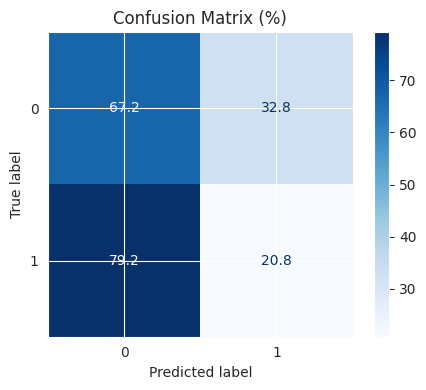

array([[67.19160105, 32.80839895],
       [79.20792079, 20.79207921]])

In [26]:
## Ukážka výsledkov pre najlepšiu binárnu klasifikáciu
from config.wandb_config import *
from config.help_functions import *
from Model import *

BINARY_CLASSIFICATION = True
BATCH_SIZE = 64
SEED = 69
LEARNING_RATE = 0.0031131517948509773
OPTIMIZER = "adam"

#===| Seed preparation |===#
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#===| Dataset |===#
X_train, X_val, y_train, y_val, train_loader, val_loader, y = (
    split("faults_reduced_normalized.csv", BINARY_CLASSIFICATION, DATA_SPLIT)
)

#===| Model preparation |===#
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SteelNet(
    X_train.shape[1],
    1,
    PARAMS,
    binary=True,
).to(device)

# Use best-found architecture
model.net = MODEL_STRUCTURE_BINARY_BEST(X_train.shape[1], 1).to(device)

#===| Training |===#
best_model, best_val_acc = model.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    logger=None,
    logging=False,
    device=device,
    max_epochs=500,
    console_output=False
)

#===| Load best weights |===#
model.load_state_dict(best_model)

#===| Evaluate and plot |===#
print("\n✅ Training finished — plotting confusion matrix...")
plot_confusion_matrix(model, val_loader, device, binary=BINARY_CLASSIFICATION)


S#

## 5 Zhrnutie našej práce

V projekte sme sa zamerali na porovnanie dvoch prístupov k detekcii chýb – **binárnej** a **multiklasifikačnej** neurónovej siete.
Oba modely boli postavené na rovnakej architektúre, no s rôznym nastavením výstupných vrstiev a parametrov učenia.
Cieľom bolo zistiť, ako konfigurácia siete ovplyvňuje jej schopnosť rozpoznať prítomnosť chyby a správne klasifikovať jej typ.

**Binárny model** sa ukázal ako jednoduchší a stabilnejší. Dosahoval vyššiu presnosť pri určovaní, či sa chyba v materiáli nachádza, keďže riešil iba dve triedy – „chybný“ a „bez chyby“.
Na druhej strane, **multiklasifikačný model** mal zložitejšiu úlohu, pretože musel rozlíšiť medzi viacerými druhmi defektov. Napriek tomu si udržal dobrú generalizačnú schopnosť a preukázal, že tá istá architektúra môže byť prispôsobená aj pre podrobnejšiu diagnostiku.

Z experimentov vyplynulo, že samotná architektúra nie je rozhodujúca, ale **správna konfigurácia parametrov** – ako sú dropout, počet neurónov alebo typ stratovej funkcie – dokáže zásadne ovplyvniť správanie siete.
Aj malé úpravy v regularizácii alebo optimalizátore viedli k odlišným výsledkom, čo potvrdzuje citlivosť modelu na zvolené nastavenie.

Celkovo možno povedať, že oba prístupy boli úspešné vo svojej oblasti – binárna sieť pre spoľahlivú detekciu a multiklasifikačná pre detailnú analýzu chýb.
Projekt ukázal, že neurónové siete dokážu efektívne riešiť aj úlohy s obmedzeným množstvom údajov, ak sú vhodne navrhnuté a optimalizované.
